In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_forecasting.data import MultiNormalizer,GroupNormalizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pool_data = pd.read_csv('PoolData.csv',on_bad_lines='skip')

In [3]:
# take a look at the data
pool_data.head()

,date,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
0,1708041600,-1.134062e+08,-1.134397e+08,-40444.288855,-1.340651e+06,6112,71218.096220
1,1708128000,-2.021456e+07,-2.022691e+07,-6543.765972,2.032085e+06,5318,61110.814054
2,1708214400,1.004206e+07,1.007014e+07,2807.137887,3.506131e+06,5947,66131.846264
3,1708300800,1.042544e+08,1.042212e+08,34278.399880,1.366455e+06,6827,118259.065975
4,1708387200,3.163059e+07,3.164884e+07,9927.220991,5.582752e+06,7136,134074.363181


In [4]:
# get some general information about the data
pool_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                990 non-null    int64  
 1   volumeUSDChange     990 non-null    float64
 2   volumeToken0Change  990 non-null    float64
 3   volumeToken1Change  990 non-null    float64
 4   tvlUSDChange        990 non-null    float64
 5   txCount             990 non-null    int64  
 6   feesUSD             990 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 54.3 KB


In [6]:
import tensorflow as tf
tf.test.is_built_with_cuda()
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-01 19:58:40.454180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 19:58:40.474551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 19:58:40.474693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
pool_data.describe()

,date,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
count,9.900000e+02,9.900000e+02,9.900000e+02,9.900000e+02,9.900000e+02,990.000000,9.900000e+02
mean,1.712275e+09,4.886174e+05,3.172368e+05,1.098578e+05,3.886413e+05,1698.201010,6.078784e+04
std,2.470334e+06,7.328615e+07,6.627237e+07,2.944746e+07,1.031125e+07,2326.680401,9.994701e+04
min,1.708042e+09,-7.469638e+08,-7.463939e+08,-3.500031e+08,-8.136680e+07,6.000000,3.321232e+00
25%,1.710115e+09,-1.179282e+07,-1.906429e+06,-2.686228e+05,-1.062848e+06,248.250000,3.824943e+03
50%,1.712275e+09,-2.034204e+05,-4.715822e+01,-3.309524e+02,1.211091e+03,745.500000,2.861033e+04
75%,1.714435e+09,1.202061e+07,7.393220e+05,3.479959e+04,1.546306e+06,1385.750000,8.214568e+04
max,1.716509e+09,7.683531e+08,7.676765e+08,2.720772e+08,9.420977e+07,10561.000000,1.781509e+06


/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


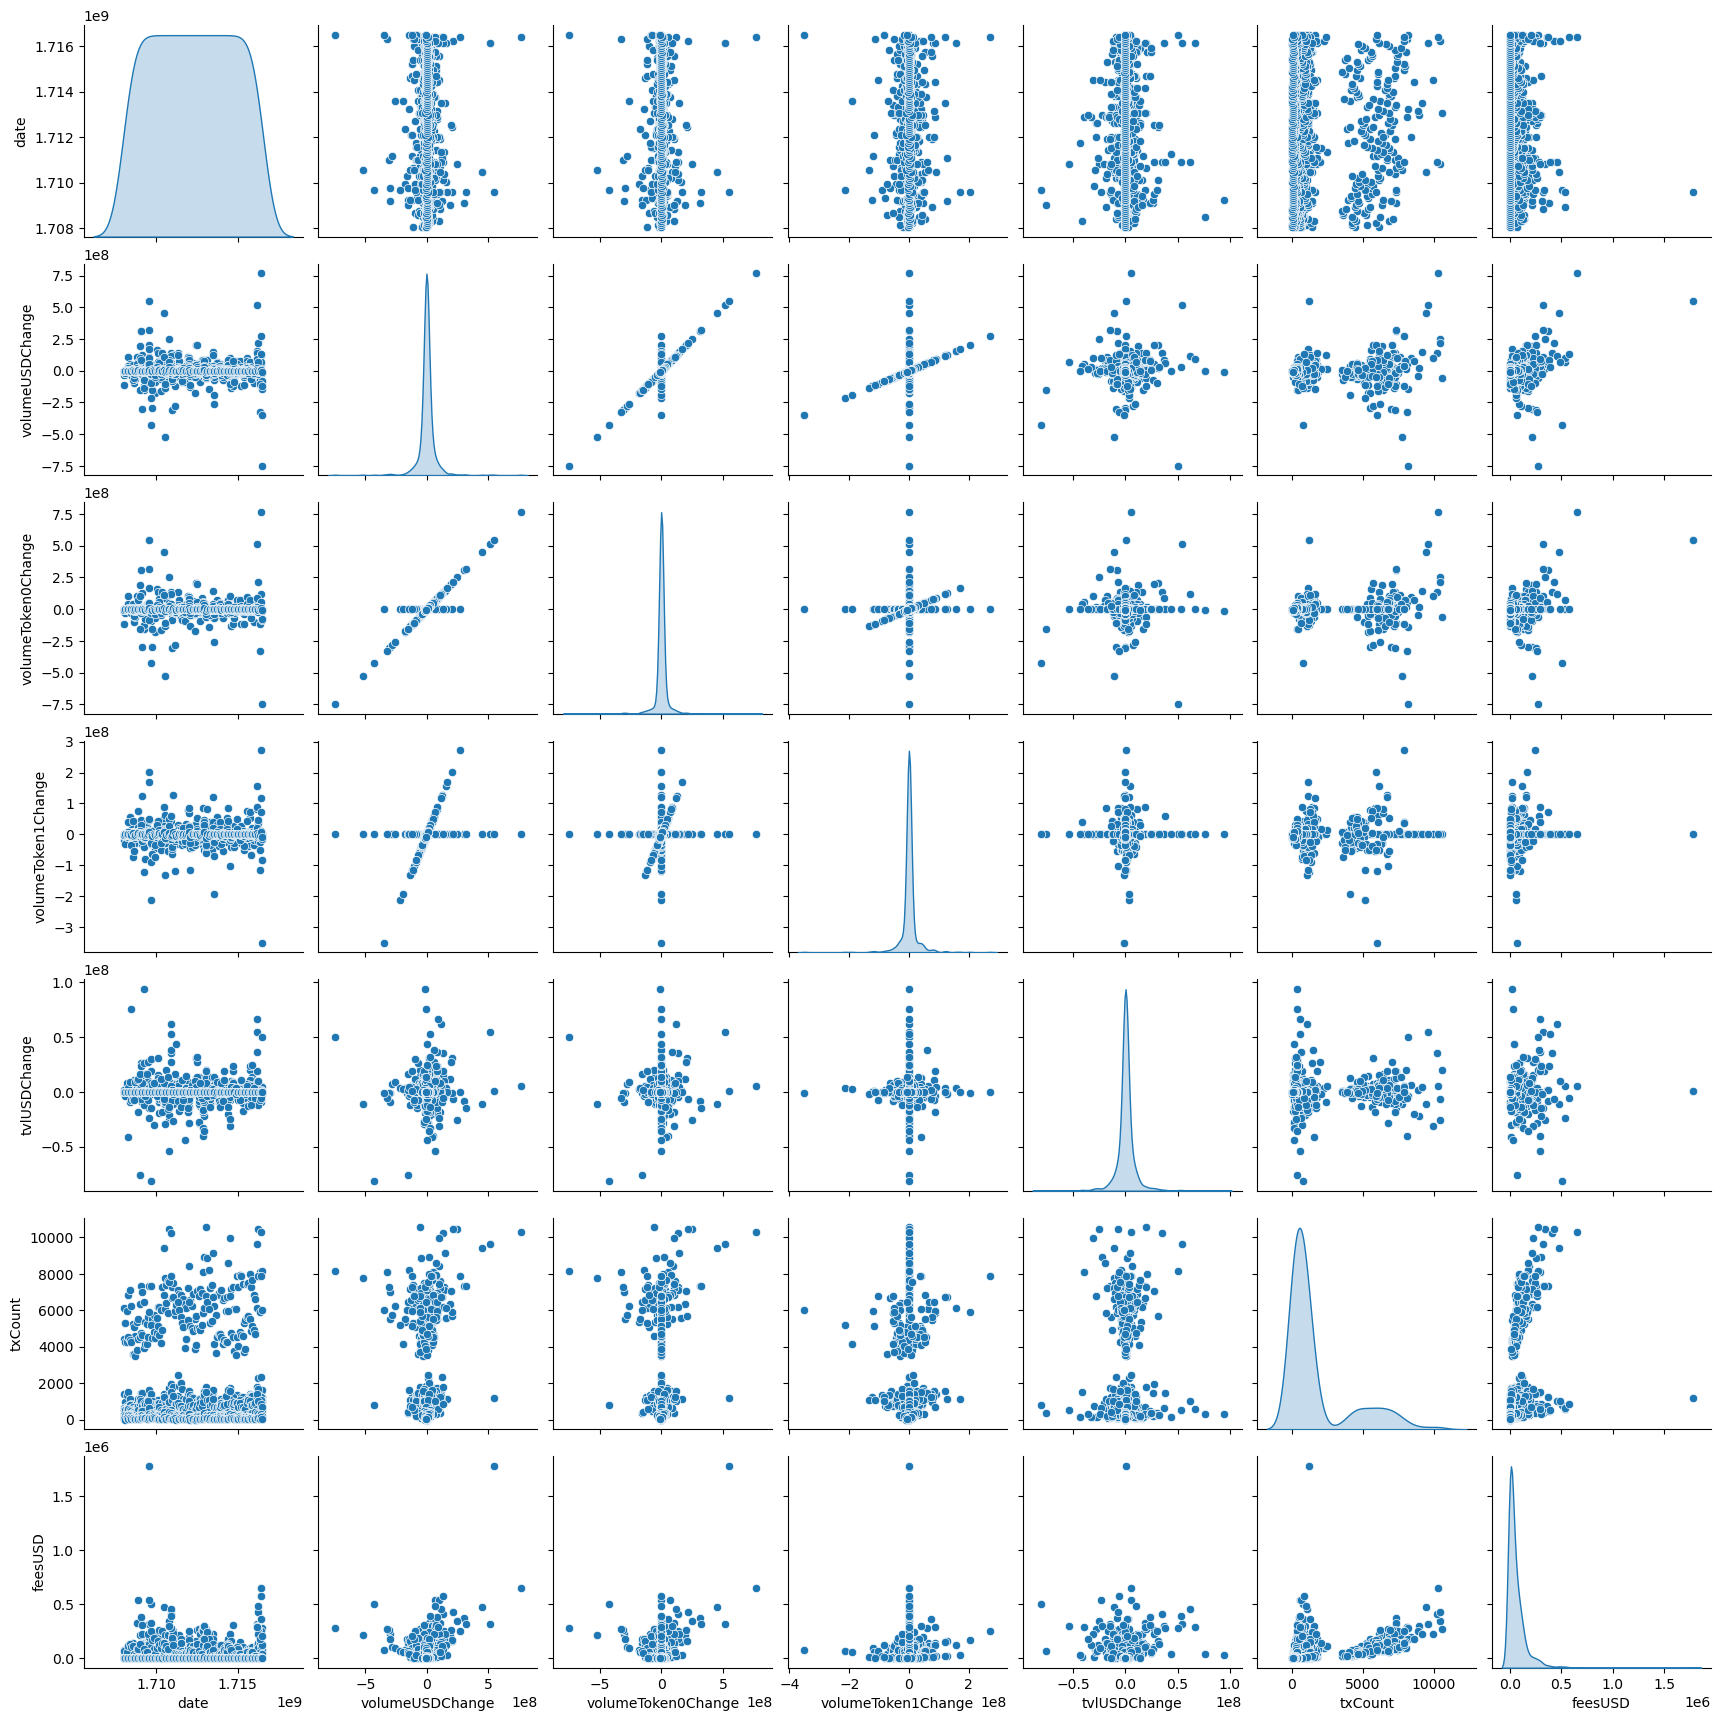

In [8]:
sns.pairplot(pool_data,kind='scatter',diag_kind='kde')

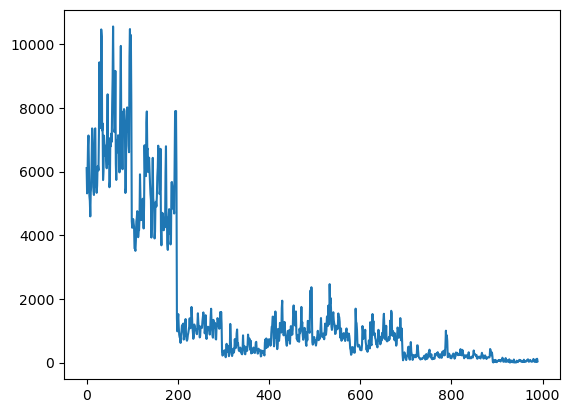

In [9]:
plt.plot(pool_data.index,pool_data[['txCount']],)

<Axes: >

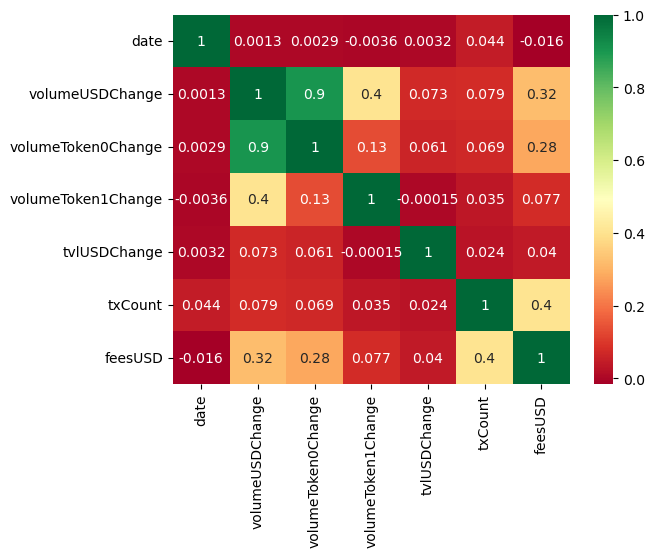

In [10]:
# get a correlation heatmap 
sns.heatmap(pool_data.corr(),cmap="RdYlGn",annot=True)

In [11]:
# drop the date axis
df = pool_data.drop('date',axis=1)

# scaled the data
scaler_txCount = MinMaxScaler()
txCount = df.txCount.values.reshape(-1,1)
scaled_txCount = scaler_txCount.fit_transform(txCount)

In [12]:
sequence_length = 60

In [13]:
# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

In [14]:
def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, y_test, y_test

In [15]:
x_train, y_train, x_test, y_test = get_train_test_sets(scaled_txCount, sequence_length, train_frac=0.9)

In [18]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
# from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = sequence_length - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

ModuleNotFoundError: No module named 'tensorflow.compat.v1.keras'

In [19]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10


2024-06-01 20:02:13.321208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:458] Loaded runtime CuDNN library: 8.7.0 but source was compiled with: 8.9.6.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-06-01 20:02:13.321709: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at cudnn_rnn_ops.cc:1779 : INVALID_ARGUMENT: Dnn is not supported
2024-06-01 20:02:13.321721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Dnn is not supported
	 [[{{function_node __inference_one_step_on_data_10272}}{{node sequential_1/lstm_1/CudnnRNNV3}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/lstm_1/CudnnRNNV3 defined at (most recent call last):
  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_28687/561688292.py", line 8, in <module>

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/models/functional.py", line 202, in call

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/models/functional.py", line 592, in call

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 560, in call

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 527, in inner_loop

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Dnn is not supported
	 [[{{node sequential_1/lstm_1/CudnnRNNV3}}]] [Op:__inference_one_step_on_iterator_10389]